In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as l
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

%matplotlib inline

In [2]:
# Fashion MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = tf.cast(x_train, tf.float32) / 255.
x_test = tf.cast(x_test, tf.float32) / 255.
y_train_cat = keras.utils.to_categorical(y_train, num_classes=10)
y_test_cat =  keras.utils.to_categorical(y_test, num_classes=10)

In [3]:
def create_simple_classifier():
    inputs = l.Input(shape=(28,28,1))
    z = l.Flatten()(inputs)
    z = l.Dense(200, activation='relu')(z)
    z = l.Dense(100, activation='relu')(z)
    output = l.Dense(10, activation='softmax')(z)
    
    return keras.Model(inputs=[inputs], outputs=[output])

In [4]:
tf.random.set_seed(42)
simple_clf = create_simple_classifier()
simple_clf.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
simple_clf.fit(x_train, y_train_cat, epochs=1)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.4820 - accuracy: 0.8275


# Custom Dense Layer - Subclassed

In [5]:
class MyDenseLayer(keras.layers.Layer):
    def __init__(self, num_neurons, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.num_neurons = num_neurons
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.w = self.add_weight(name="weights", shape=[batch_input_shape[-1], self.num_neurons], 
                                 initializer='glorot_normal')
        self.b = self.add_weight(name='bias', shape=[self.num_neurons], initializer='zeros')
        super().build(batch_input_shape) # must be at the end
        
    def call(self, x):
        return self.activation(tf.matmul(x, self.w) + self.b)
    
    # This function is actually not necessary, because keras automatically infers the shape
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.num_neurons])
        
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'num_neurons':self.num_neurons, 
                'activation':keras.activations.serialize(self.activation)}
    

In [6]:
def create_simple_classifier_custom_dense():
    inputs = l.Input(shape=(28,28,1))
    z = l.Flatten()(inputs)
    z = MyDenseLayer(200, activation='relu')(z)
    z = MyDenseLayer(100, activation='relu')(z)
    output = MyDenseLayer(10, activation='softmax')(z)
    
    return keras.Model(inputs=[inputs], outputs=[output])

In [7]:
simple_clf_custom_dense = create_simple_classifier_custom_dense()
simple_clf_custom_dense.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
tf.random.set_seed(42)
simple_clf_custom_dense.fit(x_train, y_train_cat, epochs=1)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4819 - accuracy: 0.8271


In [8]:
simple_clf_custom_dense.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
my_dense_layer (MyDenseLayer (None, 200)               157000    
_________________________________________________________________
my_dense_layer_1 (MyDenseLay (None, 100)               20100     
_________________________________________________________________
my_dense_layer_2 (MyDenseLay (None, 10)                1010      
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
_________________________________________________________________


#### Below is the same as above, but written without reference to practice

In [9]:
class MyDenseLayer2(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
    
    def build(self, batch_input_shape):
        self.w = self.add_weight(name='weights', shape=[batch_input_shape[-1], self.units],
                                 initializer='glorot_normal')
        self.b = self.add_weight(name='bias', shape=[self.units], initializer='zeros')
        super().build(batch_input_shape)
    
    def call(self, x):
        return self.activation(tf.matmul(x, self.w) + self.b)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'units':self.units, 
                'activation':keras.activations.serialize(self.activation)}

def create_simple_clf_2():
    inputs = l.Input(shape=[28,28,1])
    z = l.Flatten()(inputs)
    z = MyDenseLayer2(200, activation='relu')(z)
    z = MyDenseLayer2(100, activation='relu')(z)
    output = MyDenseLayer2(10, activation='softmax')(z)
    return keras.Model(inputs=[inputs], outputs=[output])

simple_clf_2 = create_simple_clf_2()
simple_clf_2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
tf.random.set_seed(42)
simple_clf_2.fit(x_train, y_train_cat, epochs=1)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.4809 - accuracy: 0.8268


# Multiple Inputs and Outputs

#### Lets make a class that takes two inputs and returns 3 outputs. You use tuples for multiple inputs, and a list for multiple outputs


In [10]:
class MyMultiInOut(keras.layers.Layer):
    def call(self, x):
        x1, x2 = x
        return [x1, x2, tf.matmul(x1, x2)]
        
    # It seems that this still might not have been necessary for this example too, since keras can infer the shape
    def compute_output_shape(self, batch_input_shape):
        x1_batch_shape, x2_batch_shape = batch_input_shape
        out_3_shape = tf.TensorShape(x1_batch_shape.as_list()[:-1] + [x2_batch_shape.as_list()[-1]])
        return [x1_batch_shape, x2_batch_shape, 2]  
        

#### Lets test it out

In [11]:
a = tf.constant([[1,2,3], [4,5,6]])
b = tf.constant([[1,2], [3,4], [5,6]])
MyMultiInOut().call((a,b))

[<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[1, 2, 3],
        [4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[1, 2],
        [3, 4],
        [5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[22, 28],
        [49, 64]], dtype=int32)>]

In [12]:
MyMultiInOut().compute_output_shape((a.get_shape(), b.get_shape()))

[TensorShape([2, 3]), TensorShape([3, 2]), 2]

In [13]:
inputs = l.Input(shape=[28,28])
outputs = MyMultiInOut()((inputs, inputs))

example = keras.Model(inputs=[inputs], outputs=[outputs])
out = example.predict(x_test[1])
print(len(out[0]))
for cur_out in out[0]:
    print(cur_out.shape)
    print(cur_out[0])

3
(28, 28)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.05098039 0.2627451
 0.         0.         0.         0.         0.19607843 0.14901961
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
(28, 28)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.05098039 0.2627451
 0.         0.         0.         0.         0.19607843 0.14901961
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
(28, 28)
[0.         0.         0.         0.         0.38841987 0.64741254
 0.63461745 0.54229915 0.46871206 0.64645904 0.43960017 0.45868516
 0.5387928  0.61139566 0.5243676  0.5377624  0.6224068  0.5742099
 0.3319185  0.5480354  0.39424837 0.6397693  0.6141484  0.6489351
 0.11647829 0.         0.         0.        ]


In [14]:
inputs = l.Input(shape=[28,28])
z1, z2, z3 = MyMultiInOut()((inputs, inputs))
z = l.Flatten()(z1)
z = l.Dense(200, activation='relu')(z)
z = l.Dense(100, activation='relu')(z)
output = l.Dense(10, activation='softmax')(z)


example = keras.Model(inputs=[inputs], outputs=[output])
tf.random.set_seed(42)
example.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
example.fit(x_train, y_train_cat, epochs=1)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.4820 - accuracy: 0.8275


# Train vs Test Time Behavior

In [15]:
class MyGaussianNoise(keras.layers.Layer):
    def __init__(self, std, **kwargs):
        super().__init__(**kwargs)
        self.std = std
        
    def call(self, x, training=None):
        if training:
            noise = tf.random.normal(tf.shape(x), stddev=self.std)
            return x + noise
        else:
            return x
        

In [16]:
inputs = l.Input(shape=[28,28])
z1, z2, z3 = MyMultiInOut()((inputs, inputs))
z = l.Flatten()(z1)
z = MyGaussianNoise(1)(z)
z = l.Dense(200, activation='relu')(z)
z = l.Dense(100, activation='relu')(z)
output = l.Dense(10, activation='softmax')(z)


example = keras.Model(inputs=[inputs], outputs=[output])
tf.random.set_seed(42)
example.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
example.fit(x_train, y_train_cat, epochs=1)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.9049 - accuracy: 0.6607


# Multiple Layers as a block 

### Inception Module

In [17]:
class InceptionModuleClass(keras.layers.Layer):
    def __init__(self, f1, f2_in, f2_out, f3_in, f3_out, f4_out, **kwargs):
        super().__init__(**kwargs)
        self.t_1x1 = l.Conv2D(f1, 1, activation='relu', padding='same')
        
        self.t_1x1_3x3_1 = l.Conv2D(f2_in, 1, activation='relu', padding='same')
        self.t_1x1_3x3_2 = l.Conv2D(f2_out, 3, activation='relu', padding='same')

        self.t_1x1_5x5_1 = l.Conv2D(f3_in, 1, activation='relu', padding='same')
        self.t_1x1_5x5_2 = l.Conv2D(f3_out, 5, activation='relu', padding='same')
        
        self.t_max_pool_1x1_1 = l.MaxPool2D(3, strides=[1,1], padding='same')
        self.t_max_pool_1x1_2 = l.Conv2D(f4_out, 1, activation='relu', padding='same')
        
        
        
    def call(self, x):
        t_1x1_out = self.t_1x1(x)
        
        t_1x1_3x3_out = self.t_1x1_3x3_1(x)
        t_1x1_3x3_out = self.t_1x1_3x3_2(t_1x1_3x3_out)
        
        t_1x1_5x5_out = self.t_1x1_5x5_1(x)
        t_1x1_5x5_out = self.t_1x1_5x5_2(t_1x1_5x5_out)
        
        t_max_pool_1x1_out = self.t_max_pool_1x1_1(x)
        t_max_pool_1x1_out = self.t_max_pool_1x1_2(t_max_pool_1x1_out)
        
        output = l.Concatenate()([t_1x1_out, t_1x1_3x3_out, t_1x1_5x5_out, t_max_pool_1x1_out])
        
        return output
        
        

In [18]:
module = InceptionModuleClass(16,16,16,16,16,16)
output = module.call(tf.reshape(x_test[1], (1,28,28,1)))
output.shape

TensorShape([1, 28, 28, 64])

#### Alternatively, we can simply define it as a function

In [19]:
def inception_module_fcn(x, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
        t_1x1_out = l.Conv2D(f1, 1, activation='relu', padding='same')(x)
        
        t_1x1_3x3_out = l.Conv2D(f2_in, 1, activation='relu', padding='same')(x)
        t_1x1_3x3_out = l.Conv2D(f2_out, 3, activation='relu', padding='same')(t_1x1_3x3_out)

        t_1x1_5x5_out = l.Conv2D(f3_in, 1, activation='relu', padding='same')(x)
        t_1x1_5x5_out = l.Conv2D(f3_out, 5, activation='relu', padding='same')(t_1x1_5x5_out)
        
        t_max_pool_1x1_out = l.MaxPool2D(3, strides=[1,1], padding='same')(x)
        t_max_pool_1x1_out = l.Conv2D(f4_out, 1, activation='relu', padding='same')(t_max_pool_1x1_out)
        
        output = l.Concatenate()([t_1x1_out, t_1x1_3x3_out, t_1x1_5x5_out, t_max_pool_1x1_out])
        
        return output


In [20]:
x = tf.reshape(x_test[1], (1,28,28,1))
output = inception_module_fcn(x, 16,16,16,16,16,16)
output.shape

TensorShape([1, 28, 28, 64])

In [21]:
inputs = l.Input(shape=(28,28,1))
z = InceptionModuleClass(16,16,16,16,16,16)(inputs)
z = l.MaxPool2D(2, strides=[2,2], padding='valid')(z)
z = l.Flatten()(z)
output = l.Dense(10, activation='softmax')(z)

simple_inception_model = keras.Model(inputs=[inputs], outputs=[output])

In [22]:
simple_inception_model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
inception_module_class_1 (In (None, 28, 28, 64)        8864      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                125450    
Total params: 134,314
Trainable params: 134,314
Non-trainable params: 0
_________________________________________________________________


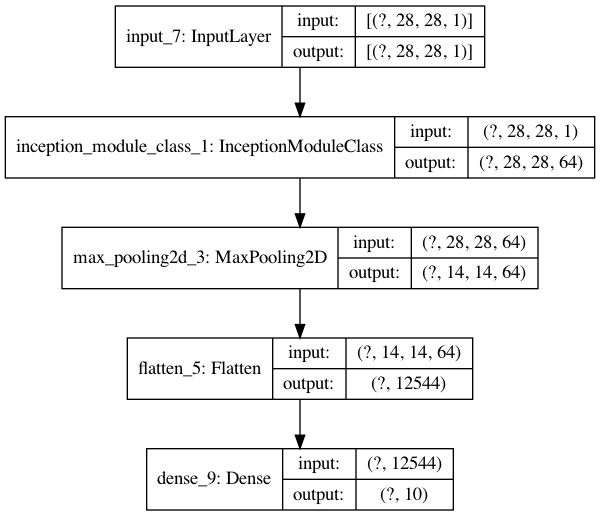

In [23]:
plot_model(simple_inception_model, show_shapes=True)

In [24]:
inputs = l.Input(shape=(28,28,1))
z = inception_module_fcn(inputs, 16,16,16,16,16,16)
z = l.MaxPool2D(2, strides=[2,2], padding='valid')(z)
z = l.Flatten()(z)
output = l.Dense(10, activation='softmax')(z)

simple_inception_model_2 = keras.Model(inputs=[inputs], outputs=[output])

In [25]:
simple_inception_model_2.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 16)   32          input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 28, 28, 16)   32          input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 28, 28, 1)    0           input_8[0][0]                    
______________________________________________________________________________________

#### Its much cleaner when we keep it as a class, as opposed to a function

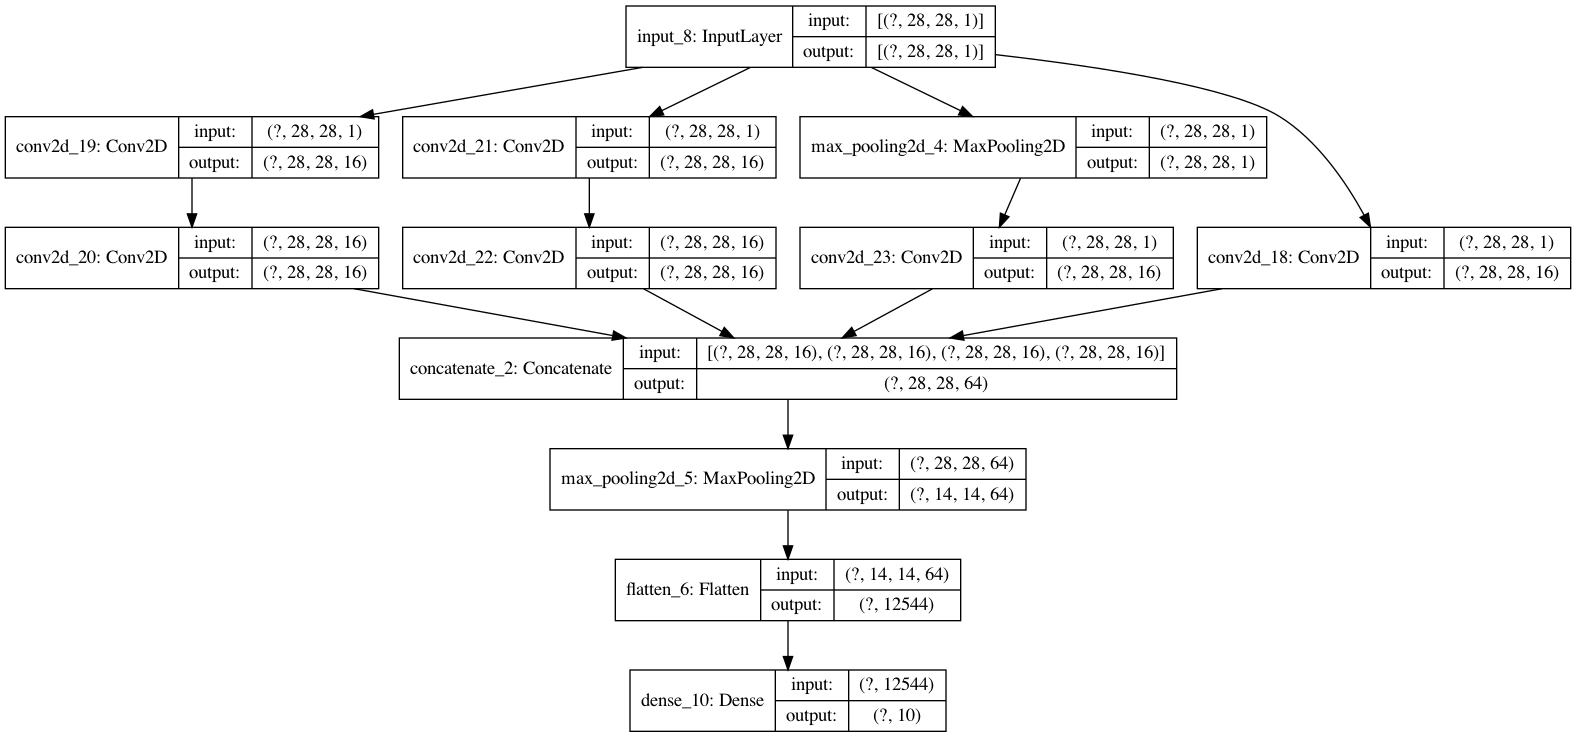

In [26]:
plot_model(simple_inception_model_2, show_shapes=True)

#### However, visually, we see all the individual components

In [27]:
tf.random.set_seed(42)
simple_inception_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
simple_inception_model.fit(x_train, y_train_cat, epochs=1)

1875/1875 [==============================] - 181s 97ms/step - loss: 0.4053 - accuracy: 0.8581
